We store the current best model in this notebook

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, \
    precision_recall_curve, auc
from sklearn.preprocessing.label import LabelBinarizer
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase, Stacked, Classifier, Regression, RegressionClassifier
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, PerElementOperator, CVOperator, df_cv_split
from utils import make_plots
from validate import pr_one_against_many

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Split the training data into folds respecting the breakpoints.

In [3]:
breakpoint_df = pd.read_csv('data/cagi5_bkpt.csv')
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[1], [0], [2], [3], [4]],
 'release_GP1BB': [[2, 1], [3], [5], [0], [4]],
 'release_HBB': [[1], [0], [2], [], []],
 'release_HBG1': [[3], [2], [1], [0], []],
 'release_HNF4A': [[0], [3], [1], [2], []],
 'release_IRF4': [[1, 2], [0, 5], [6, 3], [4], [7]],
 'release_IRF6': [[7, 1], [3, 0], [5, 2], [6, 8], [4]],
 'release_LDLR': [[3], [2], [4], [0], [1]],
 'release_MSMB': [[3, 7], [4, 2], [8, 1], [5, 0], [6]],
 'release_MYCrs6983267': [[2, 5], [4, 6], [8, 7], [1, 3], [0]],
 'release_PKLR': [[1, 2], [4, 7], [3, 0], [6], [5]],
 'release_SORT1': [[6, 0], [5, 8], [2, 7], [1, 4], [3]],
 'release_TERT-GBM': [[3], [4], [2], [0], [1]],
 'release_TERT-HEK293T': [[4], [0], [3], [2], [1]],
 'release_ZFAND3': [[8, 4, 1], [2, 10], [6, 0], [5, 3], [7, 9]]}

## Create features

In [4]:
deepseadiffs = DeepSeaSNP()
crnn_500_200 = DeepSeaSNP(filename_fmt='crnn_500_200_{}_preds.npy')
ds500_cnn3 = DeepSeaSNP(filename_fmt='ds500-cnn3-embed64-750-d20_{}_preds_v1.npy')
ds500_dq_all = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-all_{}_preds_v1.npy')
ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20_{}_preds_v1.npy')
dnase = DNase()
subst = SubstitutionOneHot()
enhancer1hot = EnhancerOneHot()
snpcontext2 = SNPContext(context_size=2)
snpcontext4 = SNPContext(context_size=4)
conservation = Conservation()
stacked = Stacked('deep-dnase-cons')

### Use tuned hyperparameters

These are taken from a kaggle kernel notebook

In [5]:
tuned_params={
    'max_depth': 2, #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': 0.6, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': 0.5, #[0.5,0.6,0.7,0.8],
    'n_estimators': 1000, #[1000,2000,3000]
    'reg_alpha': 0.03 #[0.01, 0.02, 0.03, 0.04]
}

These are tuned by Bayesian optimisation (in another notebook)

In [6]:
tuned_params = {
 'colsample_bytree': 0.7524052235178577,
 'learning_rate': 0.39783003619093765,
 'max_depth': 7,
 'min_child_weight': 4.0467095559059505,
 'reg_alpha': 0.030682622499703896,
 'reg_lambda': 0.40505823486422077,
 'subsample': 1.0
}

### Multiple features

Getting predictions for fold 0


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Getting predictions for fold 1


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Getting predictions for fold 2


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Getting predictions for fold 3


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Getting predictions for fold 4


/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7200246857026518 0.4915142320973127


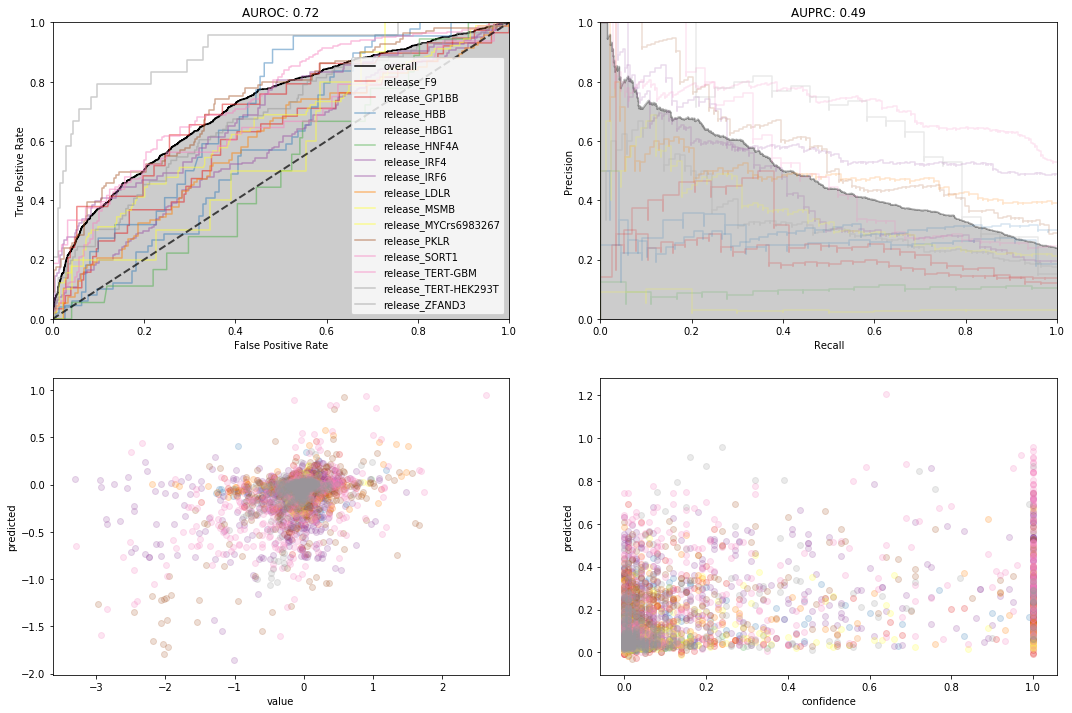

In [7]:
# features = MultiFeatures([deepseadiffs, dnase, conservation])
features = MultiFeatures([ds500_dq, dnase, conservation, stacked])
# model = Regression
regression = Regression(features)
classifier = Classifier(features)
model = RegressionClassifier
model_kwargs = {
    'regression': regression,
    'classifier': classifier,
}
cv_chunk = ChunkCV(df, operator=CVOperator(model, model_kwargs=model_kwargs), fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()
(fpr, tpr, thresholds, auroc), (precision, recall, thresholds, auprc), _, _ = make_plots(cv_regress)
print(auroc, auprc)

In [10]:
# import validate, importlib
# importlib.reload(validate)
# from validate import pr_one_against_many
preds = model.make_submission(cv_regress)
auprc_called_uncalled, auprc_positive_rest, auprc_negative_rest = pr_one_against_many(preds)
print(auprc_called_uncalled, auprc_positive_rest, auprc_negative_rest)
print(auprc_called_uncalled + auprc_positive_rest + auprc_negative_rest)

0.42050382667543407 0.11258252146134126 0.3284550302834548
0.8615413784202302


### Save best

In [11]:
cv_regress.to_csv('data/best.csv')
_ = open('data/best-AUPRC.txt', mode='w').write('{}\n'.format(auprc))
_ = open('data/best-AUROC.txt', mode='w').write('{}\n'.format(auroc))